In [51]:
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates

In [52]:
tiktok = pd.read_json('../Data/two_step_pu/xgb_TikTok_3kw.jsonl',lines=True,encoding='utf-8')
youtube = pd.read_json('../Data/two_step_pu/xgb_Youtube_3kw.jsonl',lines=True,encoding='utf-8')
twitter = pd.read_json('../Data/two_step_pu/xgb_Twitter_3kw.jsonl',lines=True,encoding='utf-8')

In [53]:
dfs = [youtube,tiktok,twitter]

In [54]:
tiktok.rename(columns={'Url':'VideoId'},inplace=True)
tiktok['PublicationDate'] = pd.to_datetime(tiktok['PublicationDate'],format='mixed')

twitter.rename(columns={'ParentId':'VideoId'},inplace=True)
twitter['PublicationDate'] = pd.to_datetime(twitter['PublicationDate'])

youtube['PublicationDate'] = pd.to_datetime(youtube['PublicationDate'],format='mixed')

In [55]:
for i,d in enumerate(dfs):
    d['OriginalScore'] = (d['OriginalScore'] > 0.5).astype(int)
    d['CommentScore'] = (d['CommentScore'] > 0.5).astype(int)
    gb = d.groupby('VideoId').count().reset_index()
    dfs[i] = d[d['VideoId'].isin(gb[gb['Comment']>=10]['VideoId'])]
    dfs[i] = dfs[i][dfs[i]['OriginalScore']==0]

In [56]:
youtube,tiktok,twitter = dfs
youtube['CommentScore'].value_counts()

CommentScore
0    1172811
1     383979
Name: count, dtype: int64

In [57]:
len(youtube)

1556790

## Exploring time/steps until shift

In [58]:
def get_delta_steps(df):
    deltas = []
    second_deltas = []
    third_deltas = []
    comments_to_first_shift = []
    comments_to_second_shift = []
    comments_to_third_shift = []
    no_p = []
    for id,video in df.groupby('VideoId'):
        video = video.sort_values('PublicationDate').reset_index(drop=True)
        video_time = video.iloc[0]['PublicationDate']
        try:
            time_to_first_p = video[video['CommentScore']==1].iloc[0]['PublicationDate']
            comments_to_first_shift.append(video[video['CommentScore']==1].index[0])
            time_delta = time_to_first_p - video_time
            deltas.append(time_delta)
        except:
            no_p.append(id)
            continue
        try:
            time_to_second_p = video[video['CommentScore']==1].iloc[1]['PublicationDate']
            comments_to_second_shift.append(video[video['CommentScore']==1].index[1]-video[video['CommentScore']==1].index[0])
            time_delta = time_to_second_p - time_to_first_p
            second_deltas.append(time_delta)
        except:
            pass
        try:
            time_to_third_p = video[video['CommentScore']==1].iloc[2]['PublicationDate']
            comments_to_third_shift.append(video[video['CommentScore']==1].index[2]-video[video['CommentScore']==1].index[1])
            time_delta = time_to_third_p - time_to_second_p
            third_deltas.append(time_delta)
        except:
            pass
    deltas = [delta.total_seconds() for delta in deltas]
    second_deltas = [delta.total_seconds() for delta in second_deltas]
    third_deltas = [delta.total_seconds() for delta in third_deltas]

    return (deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift)

(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(youtube)

In [59]:
delta_array = np.array(deltas)
print(np.mean(delta_array),np.median(delta_array))
delta_array = delta_array[np.where(delta_array < 3600)]
print(np.mean(delta_array),np.median(delta_array),len(delta_array))

23002.500121624907 307.0
514.3417992656059 106.5 3268


In [60]:
second_delta_array = np.array(second_deltas)
print(np.mean(second_delta_array),np.median(second_delta_array))
second_delta_array = second_delta_array[np.where(second_delta_array < 3600)]
print(np.mean(second_delta_array),np.median(second_delta_array),len(second_delta_array))

29953.172734314485 565.0
624.8255261371351 271.0 2946


In [61]:
third_delta_array = np.array(third_deltas)
print(np.mean(third_delta_array),np.median(third_delta_array))
third_delta_array = third_delta_array[np.where(third_delta_array < 3600)]
print(np.mean(third_delta_array),np.median(third_delta_array),len(third_delta_array))

43941.59683146681 649.0
641.8423019431988 296.5 2676


In [62]:
np.mean(comments_to_first_shift),np.mean(comments_to_second_shift),np.mean(comments_to_third_shift)

(9.528095353928485, 9.083397882778208, 10.198033324228353)

In [63]:
np.median(comments_to_first_shift),np.median(comments_to_second_shift),np.median(comments_to_third_shift)

(2.0, 2.0, 3.0)

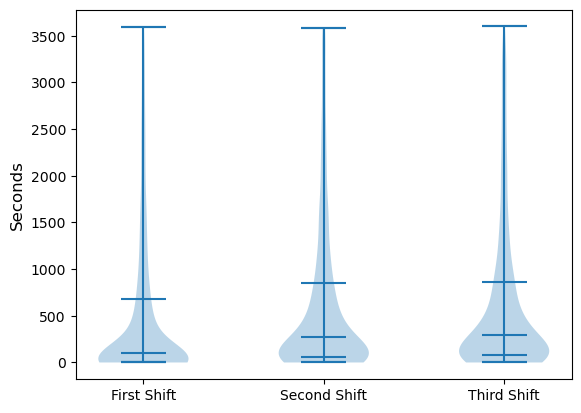

In [64]:
plt.violinplot([delta_array,second_delta_array,third_delta_array],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Seconds',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

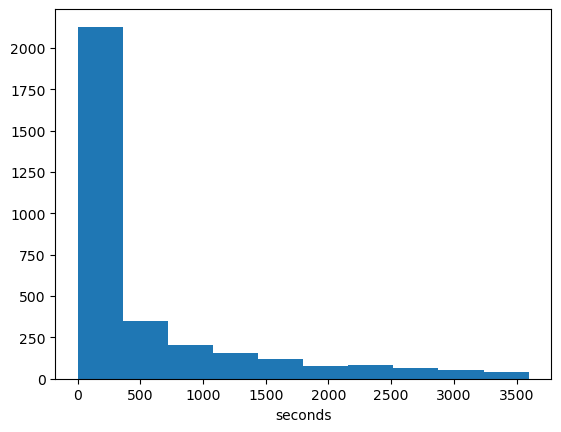

In [65]:
plt.hist(delta_array)
plt.xlabel('seconds')
plt.show()

## Exploring replies when shifty

In [66]:
youtube[(youtube['CommentScore']==1) & (youtube['ReplyCount']>0)]['ReplyCount'].describe()

count    31247.000000
mean         4.338689
std         10.920542
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        438.000000
Name: ReplyCount, dtype: float64

In [67]:
youtube[(youtube['CommentScore']==0) & (youtube['ReplyCount']>0)]['ReplyCount'].describe().apply(lambda x: format(x, 'f'))

count    160418.000000
mean          5.932084
std          16.220249
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max         495.000000
Name: ReplyCount, dtype: object

C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


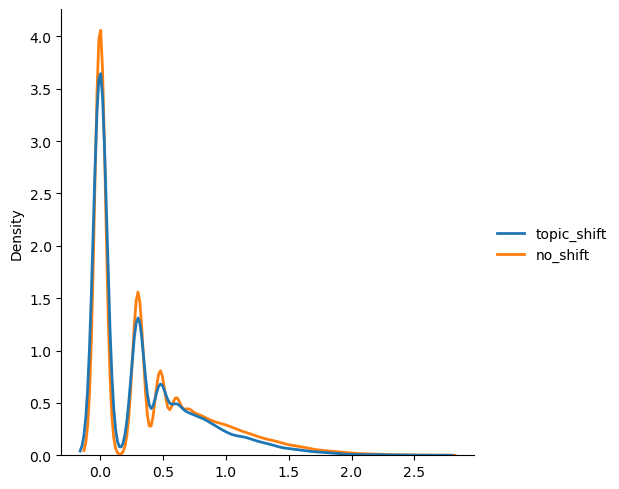

In [68]:
sns.displot(
    {
     "topic_shift": np.log10(youtube[youtube['CommentScore']==1]['ReplyCount']),
     "no_shift": np.log10(youtube[youtube['CommentScore']==0]['ReplyCount']),
    },
    kind="kde",
    common_norm=False,
    linewidth=2
)

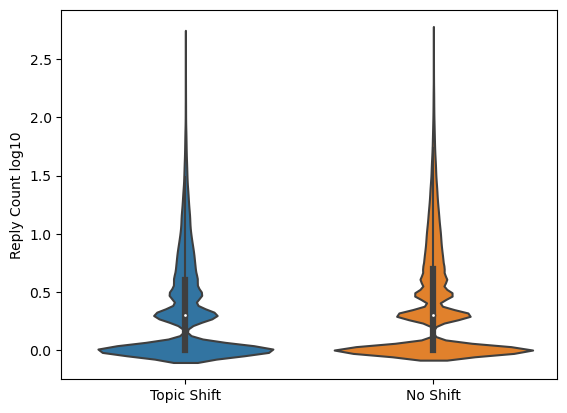

In [69]:
aux = youtube.drop(youtube[youtube['ReplyCount']==0].index)
sns.violinplot([np.log10(aux[aux['CommentScore']==1]['ReplyCount']),np.log10(aux[aux['CommentScore']==0]['ReplyCount'])],quantiles=[[0.25,0.5,0.75]]*2)
plt.xticks([0,1],['Topic Shift','No Shift'])
plt.ylabel('Reply Count log10')
plt.show()

## Ideia:

Pegar vídeos de um único tópico e ver como essas estatísticas (e.g reply count a topic shifts, "tempo até topic shift", etc) variaram com o tempo

In [70]:
topics = pd.read_csv('NP_bertopics.csv')
topics['PublicationDate'] = pd.to_datetime(topics['PublicationDate'],format='mixed')

C:\Users\msart\AppData\Local\Temp\ipykernel_10940\29782491.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  topics = pd.read_csv('NP_bertopics.csv')


In [71]:
yt=topics[topics['Platform']=='Youtube']

In [72]:
gb = yt.groupby('VideoId').count().reset_index()
yt = yt[yt['VideoId'].isin(gb[gb['Comment']>=10]['VideoId'])]

In [73]:
yt =yt[~yt['BERTopic'].isin([11,43])]

In [74]:
len(youtube)-len(yt)

36858

In [75]:
yt.groupby('VideoId').count().reset_index().sort_values(by='Original')

,VideoId,Original,OriginalScore,OC,Comment,CommentScore,CC,PublicationDate,ReplyCount,Platform,BERTopic
2574,bPMUXKqYtUM,10,10,10,10,10,10,10,10,10,10
2017,TrMtM8wClVA,10,10,10,10,10,10,10,10,10,10
3381,o23NP52zWyc,10,10,10,10,10,10,10,10,10,10
212,2AFZ8deTHIU,10,10,10,10,10,10,10,10,10,10
2957,htN7vksLOUw,10,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...,...,...
873,CS6UWDU0uSs,9791,9791,9791,9791,9791,9791,9791,9791,9791,9791
309,3XnLHk70UyE,10740,10740,10740,10740,10740,10740,10740,10740,10740,10740
1764,Q5dP-jP7lHw,11355,11355,11355,11355,11355,11355,11355,11355,11355,11355
3484,pUjx0dOunYs,11843,11843,11843,11843,11843,11843,11843,11843,11843,11843


In [76]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(yt)

In [77]:
def lots_of_statistics():
    print('-----------first deltas-------------')
    delta_array = np.array(deltas)
    print(np.mean(delta_array),np.median(delta_array))
    delta_array = delta_array[np.where(delta_array < 3600)]
    print(np.mean(delta_array),np.median(delta_array),len(delta_array))
    print('-----------second deltas-------------')
    second_delta_array = np.array(second_deltas)
    print(np.mean(second_delta_array),np.median(second_delta_array))
    second_delta_array = second_delta_array[np.where(second_delta_array < 3600)]
    print(np.mean(second_delta_array),np.median(second_delta_array),len(second_delta_array))
    print('-----------third deltas-------------')
    third_delta_array = np.array(third_deltas)
    print(np.mean(third_delta_array),np.median(third_delta_array))
    third_delta_array = third_delta_array[np.where(third_delta_array < 3600)]
    print(np.mean(third_delta_array),np.median(third_delta_array),len(third_delta_array))
    print('----------shift in comments elapsed---------------')
    print(np.mean(comments_to_first_shift),np.mean(comments_to_second_shift),np.mean(comments_to_third_shift))
    print(np.median(comments_to_first_shift),np.median(comments_to_second_shift),np.median(comments_to_third_shift))
    return delta_array,second_delta_array,third_delta_array

In [78]:
_=lots_of_statistics()

-----------first deltas-------------
23732.448588709678 334.5
529.0753031269943 117.5 3134
-----------second deltas-------------
31001.175335120643 578.0
627.2876420454545 275.0 2816
-----------third deltas-------------
45652.102899374644 679.5
645.0960784313726 300.5 2550
----------shift in comments elapsed---------------
9.842489919354838 9.358445040214477 10.548038658328595
2.0 3.0 3.0


In [79]:
split_dates = [datetime.datetime.fromisoformat('2022-07-01T00:00:00Z'),datetime.datetime.fromisoformat('2023-01-01T00:00:00Z')]

In [80]:
video_pub_dates={}
for id,video in yt.groupby('VideoId'):
    video_pub_dates[id] = video.sort_values('PublicationDate').iloc[0]['PublicationDate']

In [81]:
yt['VideoPubDate'] = yt['VideoId'].apply(lambda id: video_pub_dates[id])

In [82]:
start = yt[yt['VideoPubDate']<split_dates[0]]
mid = yt[(yt['VideoPubDate']>split_dates[0]) & (yt['VideoPubDate']<split_dates[1])]
end = yt[(yt['VideoPubDate']>split_dates[1])]

In [83]:
split_dates

[datetime.datetime(2022, 7, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2023, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)]

-----------first deltas-------------
57758.599315068495 325.5
540.510460251046 192.0 239
-----------second deltas-------------
31204.989361702126 381.0
593.056277056277 204.0 231
-----------third deltas-------------
64435.48717948718 585.0
636.6872037914692 351.0 211
----------shift in comments elapsed---------------
15.345890410958905 9.957446808510639 13.864468864468865
4.0 4.0 5.0


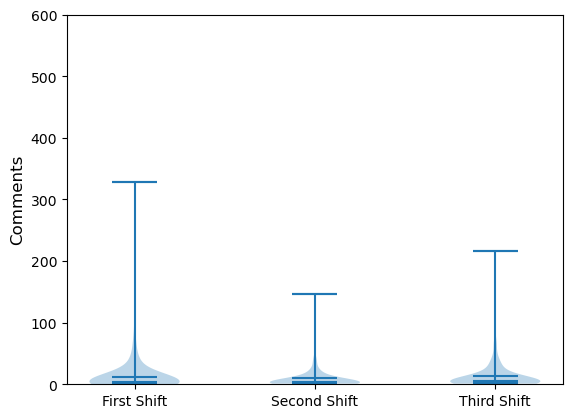

In [84]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(start)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.ylim(0,600)
plt.show()

-----------first deltas-------------
29609.084946908184 253.0
468.0335151987529 77.0 1283
-----------second deltas-------------
47290.49260752688 440.5
553.6570428696413 164.0 1143
-----------third deltas-------------
74735.62885857861 570.0
635.5264705882353 261.5 1020
----------shift in comments elapsed---------------
11.888819487820113 10.839381720430108 12.37473079684135
2.0 2.0 3.0


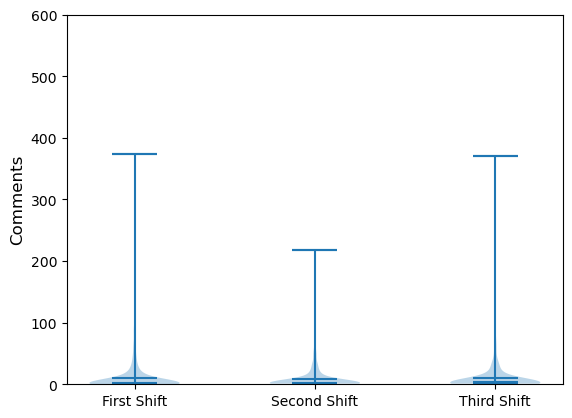

In [85]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(mid)
lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.ylim(0,600)
plt.show()

-----------first deltas-------------
14409.975903614459 421.0
575.963399503722 138.0 1612
-----------second deltas-------------
18605.267346938774 746.0
691.134535367545 359.0 1442
-----------third deltas-------------
21007.818034557236 778.0
653.841546626232 320.0 1319
----------shift in comments elapsed---------------
7.489156626506024 8.14795918367347 8.685205183585314
2.0 3.0 3.0


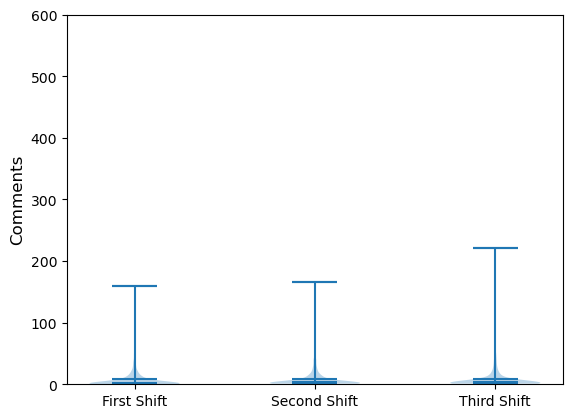

In [86]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(end)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.ylim(0,600)
plt.show()

In [87]:
## Comparing politicization percentages
start['CommentScore'].sum()/len(start),mid['CommentScore'].sum()/len(mid),end[ 'CommentScore'].sum()/len(end)

(0.12145995908780968, 0.27226901285127575, 0.24529944992722466)

In [88]:
yt['year'] = yt['PublicationDate'].apply(lambda d:d.year)
yt['week'] = yt['PublicationDate'].apply(lambda d:d.isocalendar()[1])
yt['PublicationDate'] = pd.to_datetime(yt['PublicationDate'])
yt['week_start']=yt['PublicationDate'] - pd.to_timedelta(yt['PublicationDate'].dt.dayofweek, unit='D')
yt['week_start']=pd.to_datetime(yt['week_start'].dt.strftime('%Y-%m-%d'))
yt.loc[yt['week']==52,'year']='2022'

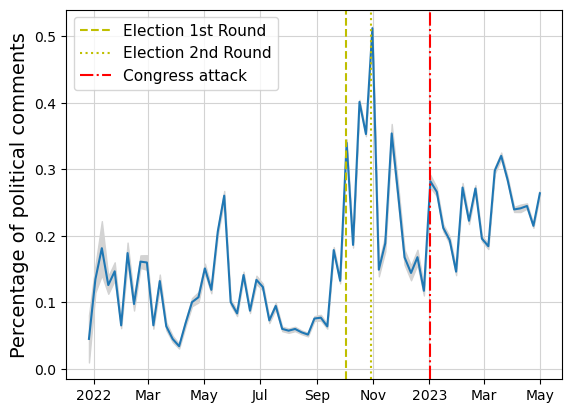

In [93]:
aux = yt.groupby(['week_start'])['CommentScore'].mean()
fig,ax =plt.subplots()
ax.plot(aux.index,aux)
confidence_interval = 1.96*yt.groupby(['week_start'])['CommentScore'].std()/np.sqrt(yt.groupby(['week_start'])['CommentScore'].count())
plt.fill_between(yt.groupby(['week_start'])['CommentScore'].mean().index, (yt.groupby(['week_start'])['CommentScore'].mean()-confidence_interval), (yt.groupby(['week_start'])['CommentScore'].mean()+confidence_interval), color='lightgray', alpha=1)
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.axvline(datetime.datetime.strptime('2022-10-02','%Y-%m-%d'),label='Election 1st Round',color='y',linestyle='--')
plt.axvline(datetime.datetime.strptime('2022-10-30','%Y-%m-%d'),label='Election 2nd Round',color='y',linestyle=':')
plt.axvline(datetime.datetime.strptime('2023-01-02','%Y-%m-%d'),label='Congress attack',color='r',linestyle='-.')
plt.legend(fontsize=11)
plt.xlabel('')
plt.ylabel('Percentage of political comments',fontsize=14)
plt.grid(color='lightgray')
plt.savefig('./figures/timeline.pdf', format='pdf')
plt.show()

In [94]:
aux.index

DatetimeIndex(['2021-12-27', '2022-01-03', '2022-01-10', '2022-01-17',
               '2022-01-24', '2022-01-31', '2022-02-07', '2022-02-14',
               '2022-02-21', '2022-02-28', '2022-03-07', '2022-03-14',
               '2022-03-21', '2022-03-28', '2022-04-04', '2022-04-11',
               '2022-04-18', '2022-04-25', '2022-05-02', '2022-05-09',
               '2022-05-16', '2022-05-23', '2022-05-30', '2022-06-06',
               '2022-06-13', '2022-06-20', '2022-06-27', '2022-07-04',
               '2022-07-11', '2022-07-18', '2022-07-25', '2022-08-01',
               '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29',
               '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26',
               '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24',
               '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21',
               '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19',
               '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16',
      

In [95]:
yt.groupby(['week_start'])['CommentScore'].mean().index

DatetimeIndex(['2021-12-27', '2022-01-03', '2022-01-10', '2022-01-17',
               '2022-01-24', '2022-01-31', '2022-02-07', '2022-02-14',
               '2022-02-21', '2022-02-28', '2022-03-07', '2022-03-14',
               '2022-03-21', '2022-03-28', '2022-04-04', '2022-04-11',
               '2022-04-18', '2022-04-25', '2022-05-02', '2022-05-09',
               '2022-05-16', '2022-05-23', '2022-05-30', '2022-06-06',
               '2022-06-13', '2022-06-20', '2022-06-27', '2022-07-04',
               '2022-07-11', '2022-07-18', '2022-07-25', '2022-08-01',
               '2022-08-08', '2022-08-15', '2022-08-22', '2022-08-29',
               '2022-09-05', '2022-09-12', '2022-09-19', '2022-09-26',
               '2022-10-03', '2022-10-10', '2022-10-17', '2022-10-24',
               '2022-10-31', '2022-11-07', '2022-11-14', '2022-11-21',
               '2022-11-28', '2022-12-05', '2022-12-12', '2022-12-19',
               '2022-12-26', '2023-01-02', '2023-01-09', '2023-01-16',
      

In [96]:
confidence_interval

week_start
2021-12-27    0.035407
2022-01-03    0.020011
2022-01-10    0.040618
2022-01-17    0.013144
2022-01-24    0.013527
                ...   
2023-04-03    0.003792
2023-04-10    0.005612
2023-04-17    0.003948
2023-04-24    0.003010
2023-05-01    0.003602
Name: CommentScore, Length: 71, dtype: float64

In [97]:
vac = yt[yt['BERTopic'].isin([21,22,45,0,18,5])]

In [98]:
start = vac[vac['VideoPubDate']<split_dates[0]]
mid = vac[(vac['VideoPubDate']>split_dates[0]) & (vac['VideoPubDate']<split_dates[1])]
end = vac[(vac['VideoPubDate']>split_dates[1])]

In [99]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(vac)

In [100]:
_=lots_of_statistics()

-----------first deltas-------------
31935.970082749842 592.0
637.9915540540541 243.0 1184
-----------second deltas-------------
40043.35540069686 735.0
662.0125361620057 303.0 1037
-----------third deltas-------------
60222.53429878049 816.0
654.4771968854283 299.0 899
----------shift in comments elapsed---------------
17.09929980903883 15.537282229965157 18.641006097560975
6.0 5.0 6.0


-----------first deltas-------------
68794.47142857143 417.5
686.0166666666667 300.5 60
-----------second deltas-------------
19554.02985074627 385.0
542.75 326.0 60
-----------third deltas-------------
10320.560606060606 345.5
485.35714285714283 226.0 56
----------shift in comments elapsed---------------
39.48571428571429 21.44776119402985 30.196969696969695
12.5 8.0 13.0


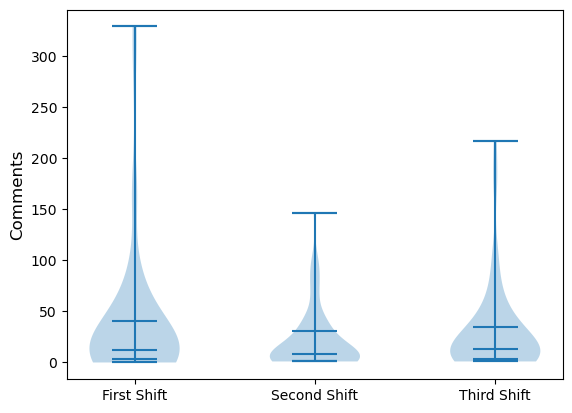

In [101]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(start)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

-----------first deltas-------------
50110.0 610.0
606.2718253968254 248.0 504
-----------second deltas-------------
64562.930693069306 814.5
647.1353919239905 253.0 421
-----------third deltas-------------
113028.70165745856 896.0
680.9 307.5 360
----------shift in comments elapsed---------------
20.218475073313783 18.724422442244226 22.773480662983424
8.0 6.0 7.0


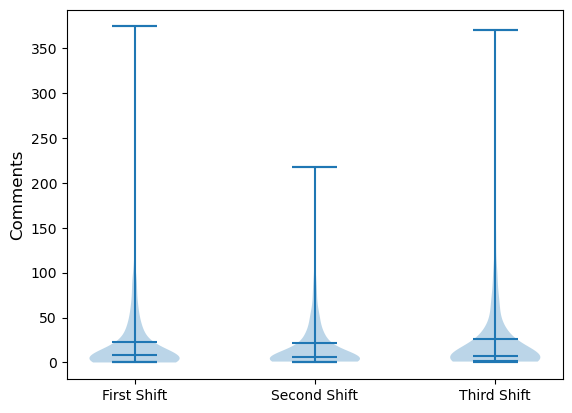

In [102]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(mid)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

-----------first deltas-------------
13651.741147741148 599.0
659.1290322580645 239.5 620
-----------second deltas-------------
22345.090551181103 750.0
686.1474820143885 329.0 556
-----------third deltas-------------
24119.805120910383 816.0
654.3913043478261 284.0 483
----------shift in comments elapsed---------------
12.588522588522588 12.482939632545932 14.364153627311522
5.0 4.0 5.0


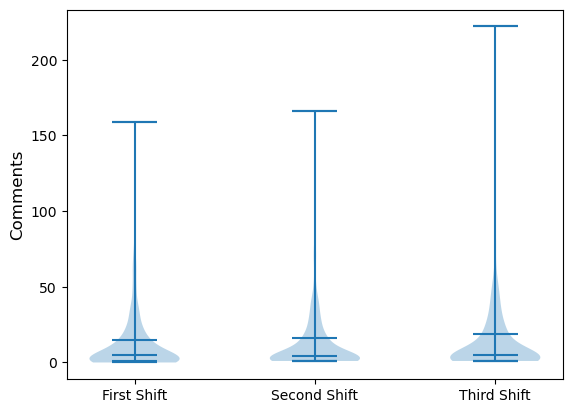

In [103]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(end)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

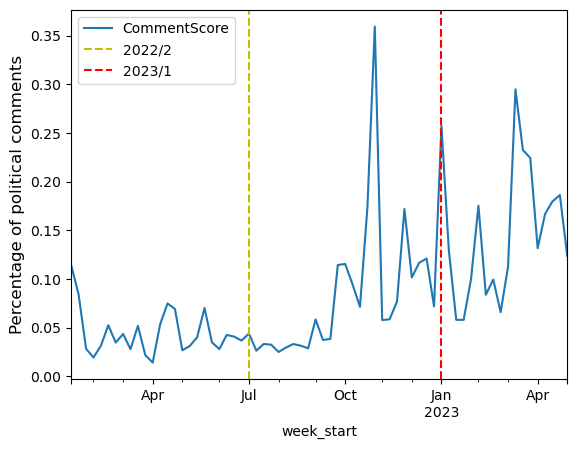

In [104]:
vac.groupby(['week_start'])['CommentScore'].mean().plot()
plt.axvline('2022-07-01',label='2022/2',color='y',linestyle='--')
plt.axvline('2023-01-01',label='2023/1',color='r',linestyle='--')
plt.legend()
plt.ylabel('Percentage of political comments',fontsize=12)
plt.show()

In [105]:
## Comparing politicization percentages
start['CommentScore'].sum()/len(start),mid['CommentScore'].sum()/len(mid),end['CommentScore'].sum()/len(end)

(0.041831665346677226, 0.09755222544408496, 0.15362577832626795)

In [106]:
vac = yt[yt['BERTopic'].isin([7,15,1,40,16])]

In [107]:
start = vac[vac['VideoPubDate']<split_dates[0]]
mid = vac[(vac['VideoPubDate']>split_dates[0]) & (vac['VideoPubDate']<split_dates[1])]
end = vac[(vac['VideoPubDate']>split_dates[1])]

In [108]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(vac)

In [109]:
_=lots_of_statistics()

-----------first deltas-------------
7307.593846153846 0.0
208.56902356902356 0.0 297
-----------second deltas-------------
5036.88198757764 160.5
414.81052631578945 118.0 285
-----------third deltas-------------
9582.640378548896 204.0
411.3103448275862 119.0 261
----------shift in comments elapsed---------------
1.4307692307692308 2.4658385093167703 2.8422712933753944
0.0 1.0 2.0


-----------first deltas-------------
1290.4615384615386 226.0
257.6666666666667 199.5 12
-----------second deltas-------------
581.8461538461538 271.0
581.8461538461538 271.0 13
-----------third deltas-------------
3691.230769230769 375.0
538.0 324.0 10
----------shift in comments elapsed---------------
2.3846153846153846 2.3076923076923075 7.153846153846154
2.0 1.0 3.0


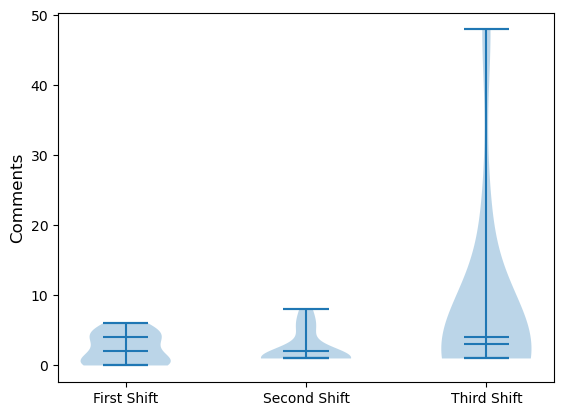

In [110]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(start)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

-----------first deltas-------------
6306.588235294118 0.0
65.64285714285714 0.0 126
-----------second deltas-------------
1917.874074074074 56.0
234.74603174603175 53.0 126
-----------third deltas-------------
6672.55223880597 68.5
323.92857142857144 52.5 112
----------shift in comments elapsed---------------
1.4558823529411764 2.2222222222222223 2.708955223880597
0.0 1.0 1.5


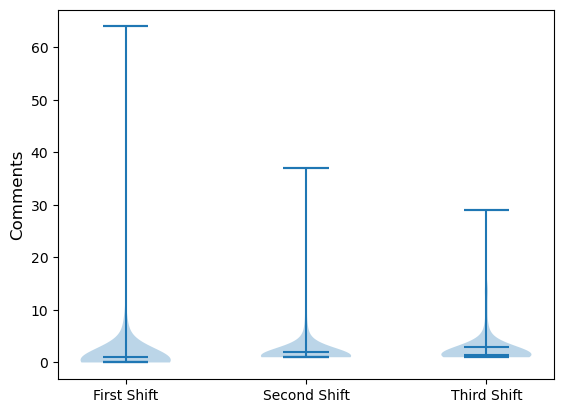

In [111]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(mid)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

-----------first deltas-------------
8525.545454545454 23.0
318.12578616352204 0.0 159
-----------second deltas-------------
7789.649425287356 367.0
555.3356164383562 289.5 146
-----------third deltas-------------
12326.994117647058 295.5
472.6043165467626 203.0 139
----------shift in comments elapsed---------------
1.3409090909090908 2.6666666666666665 2.6176470588235294
1.0 2.0 2.0


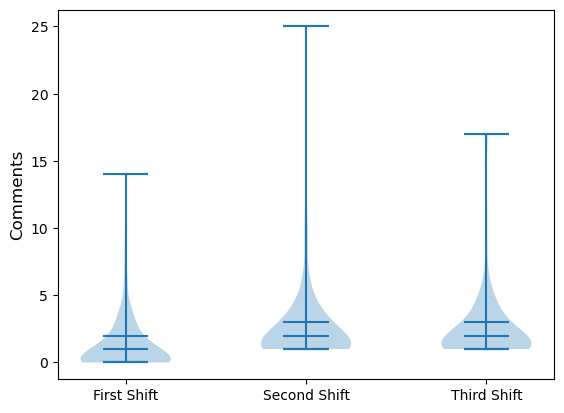

In [112]:
(deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(end)
delta_array,second_delta_array,third_delta_array=lots_of_statistics()
plt.violinplot([comments_to_first_shift,comments_to_second_shift,comments_to_third_shift],vert=True,points=1000,quantiles =[[0,0.25,0.5,0.75,1]]*3)
plt.ylabel('Comments',fontsize=12)

plt.xticks([1,2,3],['First Shift','Second Shift','Third Shift'])
plt.show()

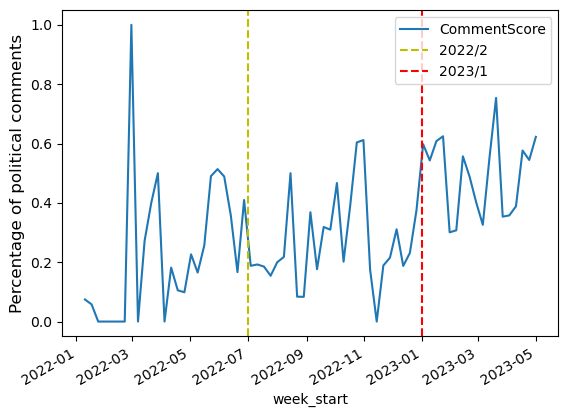

In [113]:
vac.groupby(['week_start'])['CommentScore'].mean().plot()
plt.axvline('2022-07-01',label='2022/2',color='y',linestyle='--')
plt.axvline('2023-01-01',label='2023/1',color='r',linestyle='--')
plt.legend()
plt.ylabel('Percentage of political comments',fontsize=12)
plt.show()

In [114]:
## Comparing politicization percentages
start['CommentScore'].sum()/len(start),mid['CommentScore'].sum()/len(mid),end['CommentScore'].sum()/len(end)

(0.3824400754107191, 0.5836088676893056, 0.5059958912617648)

In [115]:
len(end),len(start),len(mid)

(62793, 3713, 73796)

In [124]:
def avg_comments_to_ts(df):
    comments_to_first_shift = []
    comments_to_third_shift = []
    comments_to_second_shift = []
    comments_to_fourth_shift = []
    comments_to_shift = []
    comments_to_other_shift = []
    no_p = []
    if df.empty:
        return comments_to_shift,comments_to_first_shift,comments_to_second_shift,comments_to_third_shift
    for id,video in df.groupby('VideoId'):
        video = video.sort_values('PublicationDate').reset_index(drop=True)
        video_time = video.iloc[0]['PublicationDate']
        shifts = video[video['CommentScore']==1]
        if not shifts.empty:
            video_shifts = [shifts.index[0]]
            comments_to_first_shift.append(video_shifts[0])
            for i in range(1,len(shifts.index)):
                if i == 1:
                    comments_to_second_shift.append([shifts.index[i]-shifts.index[i-1]])
                elif i == 2:
                    comments_to_third_shift.append([shifts.index[i]-shifts.index[i-1]])
                elif i == 3:
                    comments_to_fourth_shift.append([shifts.index[i]-shifts.index[i-1]])
                video_shifts.append(shifts.index[i]-shifts.index[i-1])
            comments_to_shift.append(video_shifts)
            if len(video_shifts)>1:
                comments_to_other_shift.append(video_shifts[1:])
    return comments_to_shift,comments_to_first_shift,comments_to_second_shift,comments_to_third_shift

In [125]:
yeya = []
def shifts_per_month(df):
    global yeya
    dates = []
    median_results = pd.DataFrame(columns=['First Shift','Second Shift','Third Shift'])
    mean_results = pd.DataFrame(columns=['First Shift','Second Shift','Third Shift','Margin'])
    start_date = datetime.datetime.fromisoformat('2022-01-01T00:00:00Z')
    end_date = start_date + relativedelta(months=1)
    date_filtered_df = df[(start_date<df['VideoPubDate']) & (df['VideoPubDate']<end_date)]
    while start_date < datetime.datetime.fromisoformat('2023-06-01T00:00:00Z'):
        print(start_date,len(date_filtered_df))
        comments_to_shift,comments_to_first_shift,comments_to_second_shift,comments_to_third_shift = avg_comments_to_ts(date_filtered_df)
        aux = [i for c in comments_to_shift for i in c]
        comments_to_shift=aux
        median_results.loc[len(median_results)] = [np.median(comments_to_first_shift),np.median(comments_to_second_shift),np.median(comments_to_third_shift)]
        mean_results.loc[len(mean_results)] = [np.mean(comments_to_shift),np.mean(comments_to_second_shift),np.mean(comments_to_third_shift),1.96*np.std(comments_to_shift)/np.sqrt(len(comments_to_shift))]
        dates.append(start_date)
        start_date = end_date
        end_date = start_date + relativedelta(months=1) 
        date_filtered_df = df[(start_date<df['VideoPubDate']) & (df['VideoPubDate']<end_date)]
    mean_results.index = dates
    median_results.index = dates
    return mean_results,median_results

In [126]:
def shifts_per_week(df):
    dates = []
    median_results = pd.DataFrame(columns=['First Shift','Second Shift','Third Shift'])
    mean_results = pd.DataFrame(columns=['First Shift','Second Shift','Third Shift'])
    start_date = datetime.datetime.fromisoformat('2022-01-01T00:00:00Z')
    end_date = start_date + datetime.timedelta(days=7)
    date_filtered_df = df[(start_date<df['VideoPubDate']) & (df['VideoPubDate']<end_date)]
    while start_date < datetime.datetime.fromisoformat('2023-05-06T00:00:00Z'):
        (deltas,second_deltas,third_deltas),(comments_to_first_shift,comments_to_second_shift,comments_to_third_shift) = get_delta_steps(date_filtered_df)
        median_results.loc[len(median_results)] = [np.median(comments_to_first_shift),np.median(comments_to_second_shift),np.median(comments_to_third_shift)]
        mean_results.loc[len(mean_results)] = [np.mean(comments_to_first_shift),np.mean(comments_to_second_shift),np.mean(comments_to_third_shift),1.96*np.std(comments_to_first_shift)/np.sqrt(len(comments_to_first_shift))]
        dates.append(start_date)
        start_date = end_date
        end_date = start_date + datetime.timedelta(days=7)
        date_filtered_df = df[(start_date<df['VideoPubDate']) & (df['VideoPubDate']<end_date)]
    mean_results.index = dates
    median_results.index = dates
    return mean_results,median_results

In [127]:
m,med=shifts_per_month(yt)
np_top = yt[yt['BERTopic'].isin([21,22,45,0,18,5])]
np_m,np_med=shifts_per_month(np_top)
mp_top = yt[yt['BERTopic'].isin([7,15,1,40,16])]
p_m,p_med=shifts_per_month(mp_top)
med

2022-01-01 00:00:00+00:00 11097
2022-02-01 00:00:00+00:00 26357
2022-03-01 00:00:00+00:00 24971
2022-04-01 00:00:00+00:00 51812
2022-05-01 00:00:00+00:00 68805
2022-06-01 00:00:00+00:00 80938
2022-07-01 00:00:00+00:00 72795
2022-08-01 00:00:00+00:00 96919
2022-09-01 00:00:00+00:00 88759
2022-10-01 00:00:00+00:00 279818
2022-11-01 00:00:00+00:00 124948
2022-12-01 00:00:00+00:00 23152
2023-01-01 00:00:00+00:00 78826
2023-02-01 00:00:00+00:00 92914
2023-03-01 00:00:00+00:00 162649
2023-04-01 00:00:00+00:00 195762
2023-05-01 00:00:00+00:00 39410
2022-01-01 00:00:00+00:00 3226
2022-02-01 00:00:00+00:00 7232
2022-03-01 00:00:00+00:00 11210
2022-04-01 00:00:00+00:00 26642
2022-05-01 00:00:00+00:00 21963
2022-06-01 00:00:00+00:00 40839
2022-07-01 00:00:00+00:00 47131
2022-08-01 00:00:00+00:00 70733
2022-09-01 00:00:00+00:00 54247
2022-10-01 00:00:00+00:00 107883
2022-11-01 00:00:00+00:00 15766
2022-12-01 00:00:00+00:00 8067
2023-01-01 00:00:00+00:00 31183
2023-02-01 00:00:00+00:00 28653
2023-0

C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\msart\anaconda3\envs\icnew\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invali

2022-12-01 00:00:00+00:00 775
2023-01-01 00:00:00+00:00 9544
2023-02-01 00:00:00+00:00 12433
2023-03-01 00:00:00+00:00 14959
2023-04-01 00:00:00+00:00 18854
2023-05-01 00:00:00+00:00 7003


,First Shift,Second Shift,Third Shift
2022-01-01 00:00:00+00:00,5.5,12.0,6.0
2022-02-01 00:00:00+00:00,3.0,5.0,4.0
2022-03-01 00:00:00+00:00,3.5,7.0,5.5
2022-04-01 00:00:00+00:00,6.5,4.0,7.0
2022-05-01 00:00:00+00:00,2.0,2.0,5.0
2022-06-01 00:00:00+00:00,6.0,1.5,5.0
2022-07-01 00:00:00+00:00,5.0,3.0,6.0
2022-08-01 00:00:00+00:00,6.0,4.5,7.0
2022-09-01 00:00:00+00:00,3.0,3.0,4.0
2022-10-01 00:00:00+00:00,2.0,2.0,2.0


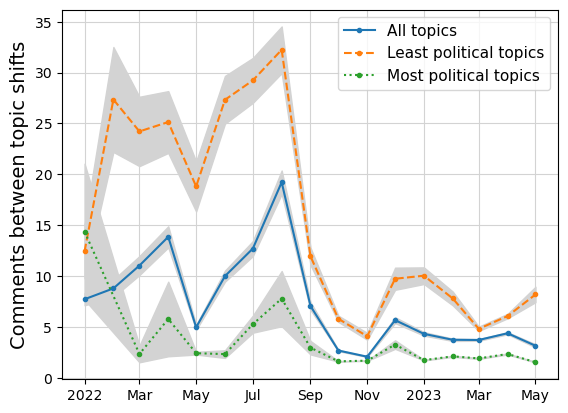

In [130]:
fig,ax = plt.subplots()
ax.plot(m['First Shift'],label='All topics',marker='.')
plt.fill_between(m.index, (m['First Shift']-m['Margin']), (m['First Shift']+m['Margin']), color='lightgray', alpha=1)
ax.plot(np_m['First Shift'],label='Least political topics',linestyle='--',marker='.')
plt.fill_between(m.index, (np_m['First Shift']-np_m['Margin']), (np_m['First Shift']+np_m['Margin']), color='lightgray', alpha=1)
ax.plot(p_m['First Shift'].dropna(),label='Most political topics',linestyle=':',marker='.')
plt.fill_between(p_m.dropna().index, (p_m.dropna()['First Shift']-p_m.dropna()['Margin']), (p_m.dropna()['First Shift']+p_m.dropna()['Margin']), color='lightgray', alpha=1)
ax.set_ylabel('Comments between topic shifts',fontsize=14)
#plt.plot(med['Second Shift'],label='second')
#plt.plot(med['Third Shift'],label='third')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend(fontsize=11)
plt.grid(color='lightgray')
plt.savefig('./Figures/mean_shifts.pdf',format='pdf')
plt.show()

In [ ]:
m,med=shifts_per_week(yt)
np_top = yt[yt['BERTopic'].isin([21,22,45,0,18,5])]
_,np_med=shifts_per_week(np_top)
mp_top = yt[yt['BERTopic'].isin([7,15,1,40,16])]
_,p_med=shifts_per_week(mp_top)
med

In [ ]:
fig,ax = plt.subplots()
ax.plot(med['First Shift'],label='All topics')
ax.plot(np_med['First Shift'],label='Least political topics',linestyle='--')
ax.plot(p_med['First Shift'],label='Most political topics',linestyle=':')
ax.set_ylabel('Comments before a topic shift',fontsize=14)
#plt.plot(med['Second Shift'],label='second')
#plt.plot(med['Third Shift'],label='third')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots()
ax.plot(med['First Shift'],label='All topics')
ax.plot(np_med.interpolate()['First Shift'],label='Least political topics',linestyle='--')
ax.plot(p_med.interpolate()['First Shift'],label='Most political topics',linestyle=':')
ax.set_ylabel('Comments before a topic shift',fontsize=12)
#plt.plot(med['Second Shift'],label='second')
#plt.plot(med['Third Shift'],label='third')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend()
plt.show()

In [ ]:
plt.plot(med['First Shift'],label='first shift')
plt.plot(med['Second Shift'],label='second shift')
plt.plot(med['Third Shift'],label='third shift')
plt.ylabel('Comments before a topic shift',fontsize=12)
plt.legend()
plt.show()
med

In [ ]:
topics=[21 , 22 , 45 , 0 , 18 , 5 , 4 , 14 , 46 , 48 , 17 , 23 , 2 , 30 , 42 , 19 , 9 , 24 , 49 , 12 , 25 , 35 , 8 , 41 , 3 , 6 , 34 , 28 , 33 , 37 , 10 , 50 , 27 , 44 , 20 , 13 , 31 , 47 , 38 , 32 , 29 , 36 , 39 , 26 , 16 , 40 , 1 , 15 , 7 , 11 , 43]
bottom_half = topics[:int(len(topics)/2)]
upper_half = topics[int(len(topics)/2):]

In [ ]:
m,med=shifts_per_month(yt)
np_top = yt[yt['BERTopic'].isin(bottom_half)]
_,np_med=shifts_per_month(np_top)
mp_top = yt[yt['BERTopic'].isin(upper_half)]
_,p_med=shifts_per_month(mp_top)
med

In [ ]:
fig,ax = plt.subplots()
ax.plot(med['First Shift'],label='All topics',marker='.')
ax.plot(np_med['First Shift'],label='Least political topics',linestyle='--',marker='.')
ax.plot(p_med['First Shift'],label='Most political topics',linestyle=':',marker='.')
ax.set_ylabel('Comments before a topic shift',fontsize=12)
#plt.plot(med['Second Shift'],label='second')
#plt.plot(med['Third Shift'],label='third')
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.legend()
plt.show()

In [ ]:
comments_to_shift=[]
comments_to_other_shift=[]
comments_to_first_shift=[]
comments_to_second_shift=[]
comments_to_third_shift=[]
comments_to_fourth_shift=[]
def avg_comments_to_ts(df):
    no_p = []
    for id,video in df.groupby('VideoId'):
        video = video.sort_values('PublicationDate').reset_index(drop=True)
        video_time = video.iloc[0]['PublicationDate']
        shifts = video[video['CommentScore']==1]
        if not shifts.empty:
            video_shifts = [shifts.index[0]]
            comments_to_first_shift.append(video_shifts[0])
            for i in range(1,len(shifts.index)):
                if i == 1:
                    comments_to_second_shift.append([shifts.index[i]-shifts.index[i-1]])
                elif i == 2:
                    comments_to_third_shift.append([shifts.index[i]-shifts.index[i-1]])
                elif i == 3:
                    comments_to_fourth_shift.append([shifts.index[i]-shifts.index[i-1]])
                video_shifts.append(shifts.index[i]-shifts.index[i-1])
            comments_to_shift.append(video_shifts)
            if len(video_shifts)>1:
                comments_to_other_shift.append(video_shifts[1:])

avg_comments_to_ts(yt)

In [ ]:
'Mean comments per shift:'+str(np.mean([np.mean(ts) for ts in comments_to_shift])) + '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_shift]))/np.sqrt(len(comments_to_shift)))

In [ ]:
'Mean comments for first shift:'+str(np.mean([np.mean(ts) for ts in comments_to_first_shift])) + '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_first_shift]))/np.sqrt(len(comments_to_first_shift)))

In [ ]:
'Mean comments to other shifts:'+str(np.mean([np.mean(ts) for ts in comments_to_other_shift])) + '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_other_shift]))/np.sqrt(len(comments_to_other_shift)))

In [ ]:
'Mean comments for second shift:'+str(np.mean([np.mean(ts) for ts in comments_to_second_shift])) + '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_second_shift]))/np.sqrt(len(comments_to_second_shift)))

In [ ]:
'Mean comments for third shift:'+str(np.mean([np.mean(ts) for ts in comments_to_third_shift]))+ '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_third_shift]))/np.sqrt(len(comments_to_third_shift)))

In [ ]:
'Mean comments for Fourth shift:'+str(np.mean([np.mean(ts) for ts in comments_to_fourth_shift]))+ '+-'+ str(1.96*(np.std([np.mean(ts) for ts in comments_to_fourth_shift]))/np.sqrt(len(comments_to_fourth_shift)))

In [ ]:
comments_to_shift = [i for c in comments_to_shift for i in c]
#comments_to_first_shift = [i for c in comments_to_first_shift for i in c]
comments_to_other_shift = [i for c in comments_to_other_shift for i in c]